In [2]:
%load_ext autoreload
%autoreload 2

from SO3 import so3_diffuser, SO3Algebra
from R3 import r3_diffuser
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import math
import math
import random
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geoopt
from geoopt.optim import (RiemannianAdam)
Stiefel = geoopt.Stiefel()
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.cm as cm

THIS CODE IS BASED ON THE FOLLOWING TWO PAPERS: 
DENOISING DIFFUSION PROBABILISTIC MODELS ON SO(3) FOR ROTATIONAL ALIGNMENT by LEACH et al
SE(3) diffusion model with application to protein backbone generation by Yim et al 

Operations on SO(3) have been taken from: https://github.com/qazwsxal/diffusion-extensions

In [3]:
import numpy as np
import torch
from scipy.spatial.transform import Rotation as SciRot

so3 = SO3Algebra()

def test_batch(batch_size: int = 8, dtype=torch.float32, device='cpu'):
    """
    Check that log_map, get_v, and exp_map agree with SciPy on a batch
    of random rotation matrices.
    """
    R_np = SciRot.random(batch_size).as_matrix()          # (B,3,3)
    R_t  = torch.tensor(R_np, dtype=dtype, device=device) # (B,3,3)

    S_skew   = so3.log_map(R_t)                 # (B,3,3)
    v_tensor = so3.get_v(S_skew)                # (B,3)
    R_recon  = so3.exp_map(v_tensor)            # (B,3,3)

    v_gt = SciRot.from_matrix(R_np).as_rotvec() # (B,3)

    v_err  = torch.linalg.norm(
        torch.tensor(v_gt, dtype=dtype, device=device) - v_tensor, dim=-1)
    R_err  = torch.linalg.norm(
        torch.tensor(R_np, dtype=dtype, device=device) - R_recon, dim=(-2, -1))

    print("Axis-angle error ‖v_gt − v_pred‖ per sample:")
    for i, e in enumerate(v_err.cpu().numpy()):
        print(f"  sample {i:02d}: {e:.3e}")

    print("\nFrobenius error ‖R − exp_map(v_pred)‖_F per sample:")
    for i, e in enumerate(R_err.cpu().numpy()):
        print(f"  sample {i:02d}: {e:.3e}")

test_batch(10)


Axis-angle error ‖v_gt − v_pred‖ per sample:
  sample 00: 1.639e-07
  sample 01: 1.686e-07
  sample 02: 1.333e-07
  sample 03: 1.192e-07
  sample 04: 3.337e-08
  sample 05: 1.686e-07
  sample 06: 1.192e-07
  sample 07: 1.193e-07
  sample 08: 5.230e-07
  sample 09: 1.333e-07

Frobenius error ‖R − exp_map(v_pred)‖_F per sample:
  sample 00: 1.273e-06
  sample 01: 6.804e-07
  sample 02: 4.086e-07
  sample 03: 8.629e-07
  sample 04: 1.127e-07
  sample 05: 6.280e-07
  sample 06: 3.517e-07
  sample 07: 2.586e-07
  sample 08: 7.522e-07
  sample 09: 2.715e-07


In [4]:
import torch, torch.nn as nn
from typing import Literal
class ResidualSE3Head(nn.Module):
    def __init__(self, feat_dim: int, d_model: int = 256,
                 hidden_dim: int = 256, n_blocks: int = 3,
                 dropout: float = 0.1):
        super().__init__()

        self.input_proj = nn.Linear(feat_dim + d_model, hidden_dim)

        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(dropout)
            ) for _ in range(n_blocks)
        ])

        self.out_rot   = nn.Linear(hidden_dim, 3)
        self.out_trans = nn.Linear(hidden_dim, 3)

    def forward(self, feats: torch.Tensor, t_emb: torch.Tensor):
        x = self.input_proj(torch.cat([feats, t_emb], dim=1))
        for blk in self.blocks:
            x = x + blk(x)
        return torch.cat([self.out_rot(x), self.out_trans(x)], dim=1)


class SE3MLP(nn.Module):
    """
    Residual-only SE(3) diffusion network with a binary conditioning flag c ∈ {0,1}.
    """
    def __init__(self, d_model: int = 256,
                 hidden_dim: int = 256,
                 n_blocks: int = 3,
                 dropout: float = 0.1):
        super().__init__()
        self.FEAT_DIM = 13                      # 9-rot + 3-trans + 1-flag

        # time embedding ϕ(t)
        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU()
        )

        # conditioning-flag embedding (two learnable biases)
        self.flag_embed = nn.Embedding(2, d_model)

        # residual head
        self.residual_head = ResidualSE3Head(
            feat_dim=self.FEAT_DIM,
            d_model=d_model,
            hidden_dim=hidden_dim,
            n_blocks=n_blocks,
            dropout=dropout
        )

    # ------------------------------------------------------------------
    def _time_flag_emb(self, t: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Return (B, d_model) time-plus-flag embedding.
        """
        B   = t.size(0)
        t_e = self.time_embed(t.view(B, 1).float())
        c_e = self.flag_embed(c.long().view(B))          # (B, d_model)
        return t_e + c_e

    # ------------------------------------------------------------------
    def forward(self,
                R_t: torch.Tensor,   # (B, 3, 3)
                T_t: torch.Tensor,   # (B, 3)
                t:   torch.Tensor,   # (B,) or scalar
                c:   torch.Tensor):  # (B,) or scalar flag {0,1}

        # ensure batch tensors
        if isinstance(t, (int, float)):
            t = torch.full((R_t.size(0),), float(t), device=R_t.device)
        if isinstance(c, (int, float)):
            c = torch.full((R_t.size(0),), int(c), device=R_t.device)

        B      = R_t.size(0)
        flat_R = R_t.reshape(B, 9)                        # (B, 9)
        feats  = torch.cat([flat_R, T_t, c.view(B, 1)], dim=1)  # (B, 13)
        emb    = self._time_flag_emb(t, c)               # (B, d_model)

        return self.residual_head(feats, emb)            # (B, 6)

In [ ]:
class se3_diffuser:
    def __init__(self, T, score = False, batch_size=64, device="cpu", betas=None, model_path = None):
        self.device      = torch.device(device)
        self.batch_size  = batch_size

        self.so3 = so3_diffuser(T, batch_size, betas, device=device)
        self.r3  = r3_diffuser(T, batch_size, betas, device=device)
        self.score = score
        
        self.model = SE3MLP(    
            d_model=256,          
            hidden_dim=256,      
            n_blocks=3,         
            dropout=0.1         
        ).to(self.device)
        if(model_path is not None): 
            self.model.load_state_dict(torch.load("se3_model_weights.pth"))
            self.model.eval()
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.T = T    

    def batch_se3(self, R_clean, T_clean, conditioning, epoch = None, gamma = 5):
        """
        R_clean : (B,3,3) 
        T_clean : (B,3)    
        """
        self.model.train()
        B = R_clean.size(0)

        t = torch.randint(1, self.T, (1,), device=self.device).item()

        R_noise, v_noise = self.so3.generate_noise(t, B)         
           
        T_noise          = self.r3.generate_noise((3,), t, B)      

        noise = T_noise / torch.sqrt(1 - self.r3.alpha_bars[int(t)]) 
        sigma_t   = torch.sqrt(1 - self.so3.alpha_bars[int(t)])   # scalar on device
        v_target  = v_noise / sigma_t                        

        R_t = self.so3.add_noise(R_clean, R_noise, t)
        T_t = self.r3.add_noise(T_clean, T_noise, t)
        pred = self.model(
                R_t,                                     # (B,3,3)
                T_t,                                     # (B,3)
                torch.full((B,), t, device=self.device), # <-- 3rd = time
                conditioning                             # <-- 4th = flag
        )
        pred_rot, pred_trans = pred[:, :3], pred[:, 3:]

        if(not self.score):
            loss = 0.5 * ((pred_rot - v_target)**2).mean() + 0.5 * ((pred_trans - noise)**2).mean()
        else: 
            loss = self.so3.compare_score(pred_rot)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


    @torch.no_grad()
    def sample(self, conditioning, stop = 1, N=1, guidance=False, optim_steps=1, cost=None):
        R_t = torch.stack([ torch.from_numpy(Rot.random().as_matrix()).float() for _ in range(N) ]).to(self.device)
        T_t = torch.randn((N, 3), device=self.device)

        for t in reversed(range(stop, self.T)):
            # predict noise
            eps = self.model(R_t, T_t,
                             torch.full((N,1), t, device=self.device), conditioning)
            eps_rot, eps_trans = eps[:, :3], eps[:, 3:]

            # rotation reverse step
            R_t = self.so3._se_sample_batch(R_t, t, eps_rot,
                                            guidance, optim_steps, cost)[1]

            # translation reverse step
            T_t = self.r3._eu_sample_batch(T_t, t, eps_trans,
                                           guidance, optim_steps, cost)
        return R_t, T_t
    

In [6]:
import torch 

def build_pose_dataset(device):
    # Pose 0  ––  z-axis +45°   ⇒  flag c = 0
    rotvec0 = np.array([0.0, 0.0, 1.0]) * (np.pi / 4)      # +45°
    R0 = torch.tensor(Rot.from_rotvec(rotvec0).as_matrix(),
                      dtype=torch.float32, device=device)
    T0 = torch.tensor([1., 0., 0.], dtype=torch.float32, device=device)
    c0 = torch.tensor(0, dtype=torch.long, device=device)   # conditioning flag

    # Pose 1  ––  z-axis −45°   ⇒  flag c = 1
    rotvec1 = np.array([0.0, 0.0, -1.0]) * (np.pi / 4)     # –45°
    R1 = torch.tensor(Rot.from_rotvec(rotvec1).as_matrix(),
                      dtype=torch.float32, device=device)
    T1 = torch.tensor([0., 0., -1.], dtype=torch.float32, device=device)
    c1 = torch.tensor(1, dtype=torch.long, device=device)   # conditioning flag

    # (optional) quick sanity-print
    print("Pose 0  R=\n", R0, "\nT=", T0, " c=", c0.item())
    print("Pose 1  R=\n", R1, "\nT=", T1, " c=", c1.item())

    # return list of (R, T, c) tuples
    return [(R0, T0, c0), (R1, T1, c1)]

def project_to_so3(M: torch.Tensor) -> torch.Tensor:
    # M: (3, 3) — single matrix
    U, _, Vt = torch.linalg.svd(M)
    R = U @ Vt

    # Ensure det(R) = +1 (not a reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt

    return R

def scale_angle_keep_axis(R: torch.Tensor, factor: float) -> torch.Tensor:
    """
    R:      (3,3) rotation matrix (torch tensor, on any device)
    factor: multiply the original rotation angle by this number
    """
    R_np     = R.cpu().numpy()
    rot      = Rot.from_matrix(R_np)
    axis     = rot.as_rotvec()
    angle    = np.linalg.norm(axis)
    if angle < 1e-8:           # identity edge-case
        return R               # nothing to scale
    axis     = axis / angle    # unit axis
    new_rot  = Rot.from_rotvec(axis * angle * factor)
    R_new    = torch.tensor(new_rot.as_matrix(),
                            dtype=R.dtype, device=R.device)
    return R_new

def build_pose_dataset_mock(device, factor=6.0):
    # original (projected) rotation matrices
    R0_raw = torch.tensor([[ 0.9988,  0.0258, -0.0414],
                           [-0.0271,  0.9992, -0.0300],
                           [ 0.0406,  0.0310,  0.9987]], dtype=torch.float32).to(device)
    
    R1_raw = torch.tensor([[ 0.9912,  0.0630, -0.1168],
                           [-0.0659,  0.9976, -0.0213],
                           [ 0.1151,  0.0288,  0.9929]], dtype=torch.float32).to(device)

    # make sure they’re exactly in SO(3)
    R0 = project_to_so3(R0_raw)
    R1 = project_to_so3(R1_raw)

    # bump up the angles
    R0_big = scale_angle_keep_axis(R0, factor)
    R1_big = scale_angle_keep_axis(R1, factor)

    # translations unchanged
    t0 = torch.tensor([ 0.1461, -0.1856,  0.3839], dtype=torch.float32, device=device)
    t1 = torch.tensor([ 0.5973, -0.3107,  0.2866], dtype=torch.float32, device=device)

    c0 = torch.tensor(0, dtype=torch.long, device=device)   # conditioning flag
    c1 = torch.tensor(1, dtype=torch.long, device=device)   # conditioning flag
    # print new angles
    for i, R_mat in enumerate([R0_big, R1_big]):
        angle_deg = SciRot.from_matrix(R_mat.cpu().numpy()).magnitude() * 180 / np.pi
        print(f"Pose {i}  new angle: {angle_deg:.3f}°")

    return [(R0_big, t0, c0), (R1_big, t1, c0)]


def train_synthetic_pairs(
        diffuser,
        dataset,             # list/array of (R, T, c) triples
        epochs: int = 100,
        log_every: int = 10_000):

    B      = diffuser.batch_size
    device = diffuser.device
    K      = len(dataset)

    losses = []

    for ep in range(1, epochs + 1):
        # ---- sample a mini-batch of indices ----
        idx = torch.randint(high=K, size=(B,))

        Rs, Ts, Cs = [], [], []
        for i in idx.tolist():
            R_i, T_i, c_i = dataset[i]         # (3,3), (3,), flag {0|1}
            Rs.append(R_i)
            Ts.append(T_i)
            Cs.append(c_i)

        Rs = torch.stack(Rs).to(device)        # (B,3,3)
        Ts = torch.stack(Ts).to(device)        # (B,3)
        Cs = torch.stack(Cs).to(device)        # (B,)  conditioning flags

        # ---- one optimizer step ----
        loss = diffuser.batch_se3(Rs, Ts, Cs, epoch=ep)

        if loss <= 10:                         # sanity filter
            losses.append(loss)

        if ep % log_every == 0:
            print(f"[pair SE(3)] epoch {ep:5d} | loss {loss:.6f}")

    return losses

Pose 0  new angle: 19.792°
Pose 1  new angle: 46.552°
[pair SE(3)] epoch 10000 | loss 0.246189
[pair SE(3)] epoch 20000 | loss 0.052056
[pair SE(3)] epoch 30000 | loss 0.213745
[pair SE(3)] epoch 40000 | loss 0.058242


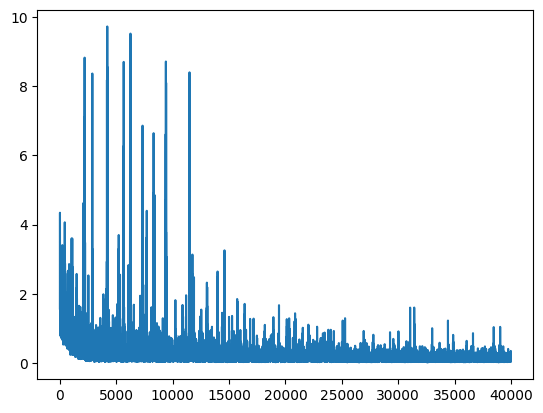

In [7]:
diffuser = se3_diffuser(T=100, batch_size=16, device="cpu")
dataset_1 = build_pose_dataset_mock("cpu", factor = 6)
losses = train_synthetic_pairs(diffuser, dataset_1, epochs = 40000)

plt.plot(losses)

Axis:  [ 0.18310199 -0.24613528 -0.15878095]
Axis:  [ 0.1507671  -0.69782649 -0.38787785]


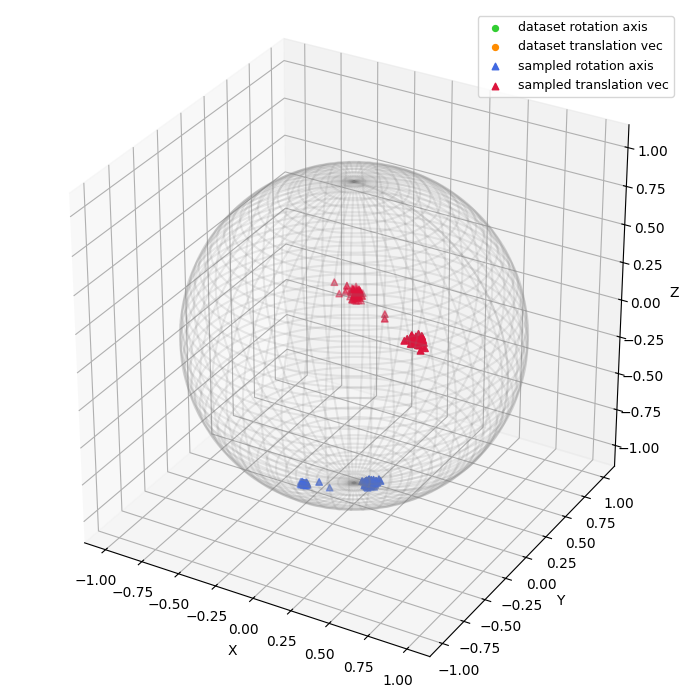

(0.812491076981062,
 array([[ 0.15278268, -0.85274598, -0.49948148],
        [ 0.16781511, -0.87234129, -0.4591936 ],
        [ 0.50330971, -0.7192265 , -0.47894945],
        [ 0.17264689, -0.854074  , -0.49066349],
        [ 0.5299339 , -0.74962038, -0.39653416],
        [ 0.51772662, -0.73373529, -0.43999053],
        [ 0.50630329, -0.72789641, -0.46241085],
        [ 0.50230337, -0.75707998, -0.41775739],
        [ 0.18454195, -0.8537659 , -0.48685527],
        [ 0.31367153, -0.81699676, -0.48386616],
        [ 0.50249403, -0.73805167, -0.45031043],
        [ 0.51807497, -0.72894189, -0.44748414],
        [ 0.16918212, -0.86783548, -0.46716057],
        [ 0.16759094, -0.86444416, -0.47397213],
        [ 0.57589097, -0.70160731, -0.41963887],
        [ 0.52284691, -0.73516608, -0.43146488],
        [ 0.1581494 , -0.87193394, -0.46337887],
        [ 0.17208333, -0.86159268, -0.47754096],
        [ 0.17344462, -0.86112648, -0.47788926],
        [ 0.17799635, -0.86469914, -0.46969426],


In [11]:
plot_samples(diffuser, dataset_1, num_samples = 100)

In [8]:
def plot_samples(diffuser, dataset, num_samples=100, stop = 1, guidance=False, optim_steps=1, cost=None):
    # ------------------------------------------------------------
    # 1. Gather sampled poses
    
    rot_axes_samp, trans_axes_samp = [], []
    for _ in range(num_samples):
        c0 = torch.randint(0, 1, (1,), dtype=torch.long, device="cpu")
        R_s, t_s = diffuser.sample(c0, stop = stop)          # Your sampler
        R_s, t_s = R_s.squeeze(0), t_s.squeeze(0)

        omega = Rot.from_matrix(R_s).as_rotvec()
        theta = np.linalg.norm(omega)
        axis  = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes_samp.append(axis)
        trans_axes_samp.append(t_s.cpu().numpy())  # No normalization to preserve magnitude info
        #print("norm", np.linalg.norm(t_s))

    rot_axes_samp   = np.stack(rot_axes_samp)   # (Ns, 3)
    trans_axes_samp = np.stack(trans_axes_samp) # (Ns, 3)

    # ------------------------------------------------------------
    # 2. Gather dataset poses (limit to 200 for speed)
    max_ds = min(len(dataset), 200)
    rot_axes_ds, trans_axes_ds = [], []
    for i in range(max_ds):
        item = dataset[i]
        if isinstance(item, dict):
            R_i = item["R"].cpu().numpy()
            t_i = item["t"].cpu().numpy()
        else:  # handle tuple-style dataset like [(R0, t0), (R1, t1)]
            R_i, t_i, _ = item
            R_i = R_i.cpu().numpy()
            t_i = t_i.cpu().numpy()

        omega = Rot.from_matrix(R_i).as_rotvec()
        print("Axis: ", omega)
        theta = np.linalg.norm(omega)
        axis  = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes_ds.append(axis)
        trans_axes_ds.append(t_i)

    rot_axes_ds   = np.stack(rot_axes_ds)    # (Nd, 3)
    trans_axes_ds = np.stack(trans_axes_ds)  # (Nd, 3)

    # ------------------------------------------------------------
    # 3. Plot
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(111, projection='3d')

    # dataset = green/orange
    ax.scatter(rot_axes_ds[:, 0], rot_axes_ds[:, 1], rot_axes_ds[:, 2],
               c='limegreen', s=18, label='dataset rotation axis')
    ax.scatter(trans_axes_ds[:, 0], trans_axes_ds[:, 1], trans_axes_ds[:, 2], c='darkorange', s=18, label='dataset translation vec')

    # samples = blue/red
    
    ax.scatter(rot_axes_samp[:, 0], rot_axes_samp[:, 1], rot_axes_samp[:, 2], c='royalblue', s=22, label='sampled rotation axis', marker='^')
    ax.scatter(trans_axes_samp[:, 0], trans_axes_samp[:, 1], trans_axes_samp[:, 2], c='crimson', s=22, label='sampled translation vec', marker='^')
    

    # unit sphere wireframe for orientation
    u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.15)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc="upper right", fontsize=9)
    plt.tight_layout()
    plt.show()

    return theta, rot_axes_samp

def plot_samples_correlation(diffuser, num_samples=100, guidance=False, optim_steps=1, cost=None):
    rot_axes, trans_axes = [], []

    for _ in range(num_samples):
        R_sample, t_sample = diffuser.sample(stop = 1)
        R_sample, t_sample = R_sample.squeeze(0), t_sample.squeeze(0)

        omega = Rot.from_matrix(R_sample).as_rotvec()
        theta = np.linalg.norm(omega)
        axis  = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes.append(axis)

        t_sample = t_sample #/ (np.linalg.norm(t_sample) + 1e-8)

        trans_axes.append(t_sample) 

    rot_axes, trans_axes = np.stack(rot_axes), np.stack(trans_axes)

    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(111, projection='3d')

    cmap   = cm.get_cmap("tab20", num_samples)
    colours = cmap(np.arange(num_samples))

    for i, colour in enumerate(colours):
        ax.scatter(*rot_axes[i],  c=[colour], marker='^', s=50, label=None)
        ax.scatter(*trans_axes[i], c=[colour], marker='o', s=50, label=None)
        ax.plot([rot_axes[i,0], trans_axes[i,0]],
                [rot_axes[i,1], trans_axes[i,1]],
                [rot_axes[i,2], trans_axes[i,2]],
                c=colour, alpha=0.5, linewidth=1)

    u, v = np.linspace(0, 2*np.pi, 60), np.linspace(0, np.pi, 30)
    x, y = np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v))
    z    = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.15, linewidth=0.3)

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    plt.show()

    return rot_axes, trans_axes

def plot_rotations(diffuser, dataset, num_samples=100, stop=1):
    # -------------------------------
    # 1. Gather sampled rotations
    rot_axes_samp, angles_samp = [], []
    for _ in range(num_samples):
        c0 = torch.randint(0, 2, (1,), dtype=torch.long, device="cpu")
        R_s, _ = diffuser.sample(c0, stop=stop)
        R_s = R_s.squeeze(0)

        omega = Rot.from_matrix(R_s).as_rotvec()
        theta = np.linalg.norm(omega)
        axis = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes_samp.append(axis)
        angles_samp.append(theta)

    rot_axes_samp = np.stack(rot_axes_samp)
    angles_samp = np.array(angles_samp)

    # -------------------------------
    # 2. Gather dataset rotations
    max_ds = min(len(dataset), 200)
    rot_axes_ds, angles_ds = [], []
    for i in range(max_ds):
        item = dataset[i]
        if isinstance(item, dict):
            R_i = item["R"].cpu().numpy()
        else:
            R_i, _, _ = item
            R_i = R_i.cpu().numpy()

        omega = Rot.from_matrix(R_i).as_rotvec()
        theta = np.linalg.norm(omega)
        axis = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes_ds.append(axis)
        angles_ds.append(theta)

    rot_axes_ds = np.stack(rot_axes_ds)
    angles_ds = np.array(angles_ds)

    # -------------------------------
    # 3. Plot
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize color based on angle
    all_angles = np.concatenate([angles_samp, angles_ds])
    norm = Normalize(vmin=all_angles.min(), vmax=all_angles.max())
    cmap = cm.get_cmap('viridis')

    ax.scatter(rot_axes_ds[:, 0], rot_axes_ds[:, 1], rot_axes_ds[:, 2],
           c=cm.plasma(norm(angles_ds)), marker='x', s=25,
           label='GT Rotation Axis', edgecolors='black')

    # Sampled with viridis colormap, larger '^' marker
    ax.scatter(rot_axes_samp[:, 0], rot_axes_samp[:, 1], rot_axes_samp[:, 2],
            c=cm.viridis(norm(angles_samp)), marker='^', s=60,
            label='Sampled Rotation Axis', alpha=0.9)

    # Add unit sphere wireframe
    u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.1)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc="upper right", fontsize=9)

    # Colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    mappable.set_array(angles_samp)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    cbar.set_label("Sampled Rotation Angle (rad)")


    plt.tight_layout()
    plt.show()

    return angles_samp, rot_axes_samp

In [9]:
def visualize_so3_probabilities(
    rotations,                 # (N,3,3) array
    probabilities,             # (N,) array
    rotations_gt=None,         # optional (M,3,3) or (3,3)
    ax=None,
    fig=None,
    display_threshold_probability=0.0,
    to_image=True,
    show_color_wheel=True,
    canonical_rotation=np.eye(3),
):
    """
    Tilt-coloured view of a distribution on SO(3) — SciPy-only version.
    """

    # --------------------------------------------------------- helpers
    def _axis_angle_to_lon_lat(R_single):
        """
        Convert a single 3×3 matrix to (longitude, latitude, tilt_angle)
        following the 'tilt-swing' visualisation convention:
          * longitude, latitude → direction of the +X body axis
          * tilt (hue) → rotation about that axis
        """
        rot = SciRot.from_matrix(R_single)
        eulers = rot.as_euler('xyz', degrees=False)   # (roll=pitch=yaw if XYZ)
        tilt   = eulers[0]                            # first Euler (about body-X)

        axis_dir = R_single[:, 0]                     # body-X axis expressed in world
        lon  = np.arctan2(axis_dir[0], -axis_dir[1])
        lat  = np.arcsin(axis_dir[2])
        return lon, lat, tilt

    def _scatter_marker(ax, R_single, marker, edge=True, face=False):
        lon, lat, tilt = _axis_angle_to_lon_lat(R_single)
        color = cmap(0.5 + tilt / (2 * np.pi))
        ax.scatter(lon, lat,
                   s=2500,
                   edgecolors=color if edge else 'none',
                   facecolors=color if face else 'none',
                   marker=marker, linewidth=4)

    # --------------------------------------------------------- figure setup
    if ax is None:
        fig = plt.figure(figsize=(8, 4), dpi=100)
        ax  = fig.add_subplot(111, projection='mollweide')

    cmap = plt.cm.hsv
    scatter_scaling = 1

    # --------------------------------------------------------- display rotations
    R_disp = rotations @ canonical_rotation
    lons, lats, tilts = [], [], []
    for R in R_disp:
        lon, lat, tilt = _axis_angle_to_lon_lat(R)
        lons.append(lon)
        lats.append(lat)
        tilts.append(tilt)

    lons  = np.array(lons)
    lats  = np.array(lats)
    tilts = np.array(tilts)

    mask = probabilities > display_threshold_probability
    ax.scatter(lons[mask],
               lats[mask],
               s = scatter_scaling * probabilities[mask],
               c = cmap(0.5 + tilts[mask] / (2 * np.pi)))

    # --------------------------------------------------------- ground-truth markers
    if rotations_gt is not None:
        R_gt = rotations_gt[np.newaxis] if rotations_gt.ndim == 2 else rotations_gt
        for R in R_gt @ canonical_rotation:
            _scatter_marker(ax, R, marker='o', edge=True,  face=False)
            _scatter_marker(ax, R, marker='o', edge=False, face=True)  # white fill

    # --------------------------------------------------------- cosmetics
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if show_color_wheel:
        inset = fig.add_axes([0.86, 0.17, 0.12, 0.12], projection='polar')
        theta = np.linspace(-3*np.pi/2,  np.pi/2, 200)
        radii = np.linspace(0.4, 0.5, 2)
        _, T = np.meshgrid(radii, theta)
        inset.pcolormesh(theta, radii, (0.5 + T / (2*np.pi)).T, cmap=cmap)
        inset.set_yticklabels([])
        inset.set_xticklabels([r'90°', None, r'180°', None, r'270°', None, r'0°'])
        inset.spines['polar'].set_visible(False)
        inset.text(0.5, 0.5, 'Tilt', fontsize=13,
                   ha='center', va='center', transform=inset.transAxes)

    if to_image:
        return plot_to_image(fig)   # use your existing helper
    return fig

def visualize_se3_tilt_angles(
        diffuser,
        dataset=None,
        num_samples: int = 200,
        stop: int = 1,
        show_color_wheel: bool = True,
        canonical_rotation: np.ndarray = np.eye(3),
):
    """
    Sample `num_samples` rotations via diffuser.sample(...)
    and display their axis direction + tilt angle distribution.

    Args
    ----
    diffuser  : trained se3_diffuser instance
    dataset   : optional list of (R,T,c) to over-plot as GT
    num_samples : number of rotations to draw
    stop      : smallest timestep for reverse process
    """
    # ---- 1. Draw samples ----
    R_samp = []
    for _ in range(num_samples):
        c_flag = torch.randint(0, 2, (1,), dtype=torch.long, device="cpu")
        R_s, _ = diffuser.sample(c_flag, stop=stop)
        R_samp.append(R_s.squeeze(0).cpu().numpy())
    R_samp = np.stack(R_samp)                         # (N,3,3)

    # ---- 2. Build probability weights (uniform) ----
    prob = np.ones(num_samples) / num_samples

    # ---- 3. Gather ground-truth rotations, if provided ----
    R_gt = None
    if dataset is not None:
        R_gt = np.stack([item[0].cpu().numpy() for item in dataset])

    # ---- 4. Visualise ----
    visualize_so3_probabilities(
        rotations     = R_samp,
        probabilities = prob,
        rotations_gt  = R_gt,
        show_color_wheel = show_color_wheel,
        canonical_rotation = canonical_rotation,
        to_image=False
    )

/var/folders/9q/pw8p78j55rvgrvdqkq43f2m00000gn/T/ipykernel_67320/1968401442.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  inset.set_xticklabels([r'90°', None, r'180°', None, r'270°', None, r'0°'])


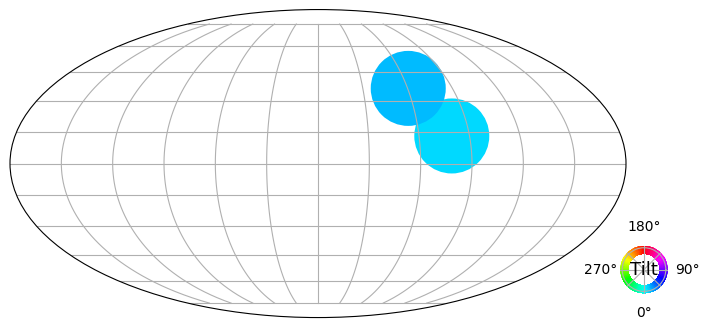

In [10]:
visualize_se3_tilt_angles(
    diffuser        = diffuser,
    dataset         = dataset_1,   # or None
    num_samples     = 100,
    stop            = 1,
    show_color_wheel= True
)

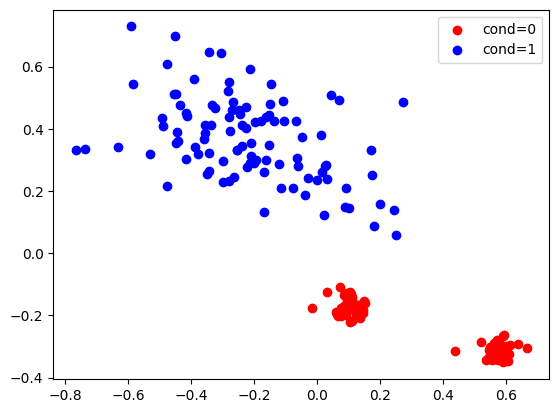

In [12]:
device = "cpu"
for c in [0, 1]:
    t_preds = []
    for _ in range(100):
        _, t = diffuser.sample(conditioning=torch.tensor([c], device=device))
        t_preds.append(t.squeeze(0).cpu().numpy())
    t_preds = np.stack(t_preds)
    plt.scatter(t_preds[:,0], t_preds[:,1], c='r' if c==0 else 'b', label=f'cond={c}')
plt.legend()
plt.show()